In [1]:
import pandas as pd
import geopandas as gpd
import requests
import os
import shutil
import matplotlib.pyplot as plt
import sys
import numpy as np
import datetime
import folium
import shapely
import scipy
import skimage
from shapely.geometry import Polygon, MultiPolygon
from shapely.affinity import translate, scale
import datetime

## Load supporting data

In [409]:
COUNTY_LIST = {
    "Delaware":"041",
    "Fairfield":"045",
    "Fayette":"047",
    "Franklin":"049",
    "Hocking":"073",
    "Knox":"083",
    "Licking":"089",
    "Logan":"091",
    "Madison":"097",
    "Marion":"101",
    "Morrow":"117",
    "Perry":"127",
    "Pickaway":"129",
    "Ross":"141",
    "Union":"159"
}

walk_speed = 2.5 * 1.6  # km/h = mph * 1.6 km/mile
bike_speed = 15 * 1.6  # km/h = mph * 1.6 km/mile

In [410]:
region = gpd.read_file("./temp_data/region.shp")
region = region.to_crs(epsg=4326)
counties = gpd.read_file("./temp_data/counties.shp")
counties = counties.to_crs(epsg=4326)
tracts = gpd.read_file("./temp_data/tracts.shp")
tracts = tracts.to_crs(epsg=4326)
site = gpd.read_file("./input_data/site/site.shp")
site = site.to_crs(epsg=4326)
park_and_ride = gpd.read_file("./temp_data/park_and_ride.shp")
park_and_ride = park_and_ride.to_crs(epsg=4326)
points = gpd.read_file("./temp_data/points.shp")
points = points.to_crs(epsg=4326)
tract_points = gpd.read_file("./temp_data/tract_points.shp")
tract_points = tract_points.to_crs(epsg=4326)
blocks = gpd.read_file("./temp_data/blocks.shp")
blocks = blocks.to_crs(epsg=4326)

<AxesSubplot:>

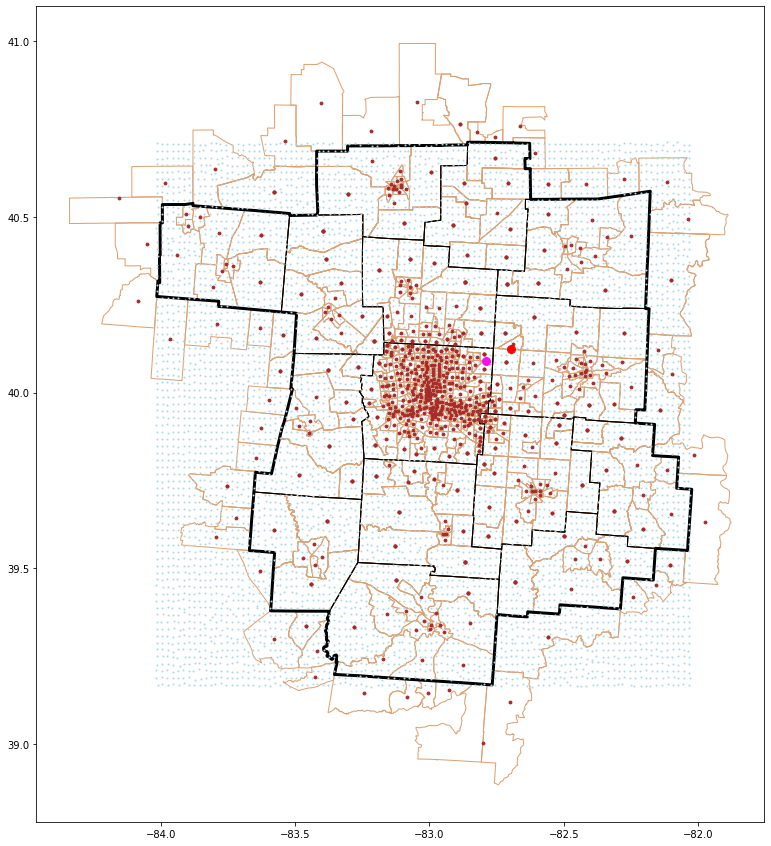

In [411]:
ax = tracts.plot(edgecolor="#dda071", facecolor="none", figsize=(15,15))
counties.plot(ax=ax, edgecolor="black", facecolor="none")
region.plot(ax=ax, linewidth=3, edgecolor="black", facecolor="none")
points.plot(ax=ax, color="lightblue", markersize=1)
tract_points.plot(ax=ax, color="brown", markersize=8)
site.plot(ax=ax, color="red", markersize=64)
park_and_ride.plot(ax=ax, color="#fc0cf4", markersize=64)

## Compute travel times between origin and destinations

In [412]:
ttm = pd.read_csv("./output_data/ttm_CAR_outbound_neighborhoods.csv")
ttm["fromId"] = ttm["fromId"].astype("string")
ttm["toId"] = ttm["toId"].astype("string")
ttm_points = tract_points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

m = counties.explore(tiles="OpenStreetMap", style_kwds={"color":"black", "weight":2, "fill":False})
ttm_points.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

## Create travel time isochrones

### Car

In [413]:
ttm = pd.read_csv("output_data/ttm_CAR_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [414]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [415]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [416]:
tightgrid["travel_time"] = z

<AxesSubplot:>

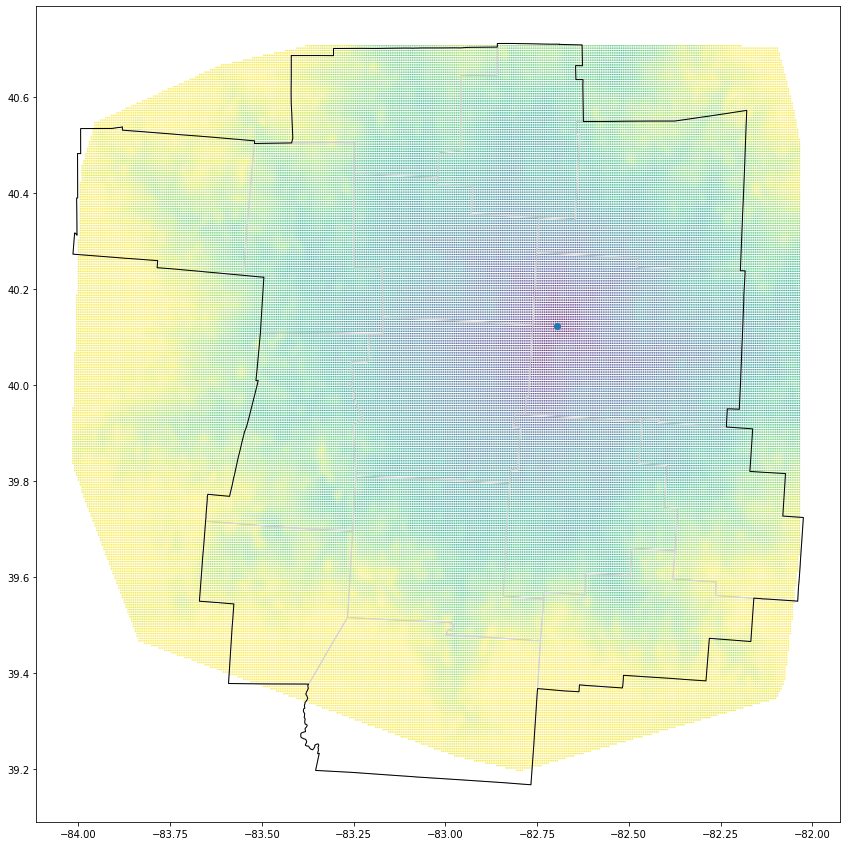

In [417]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [418]:
Z = z.reshape((len(y),len(x)))

Generating isochrone for budget 10
Generating isochrone for budget 20
Generating isochrone for budget 30
Generating isochrone for budget 40
Generating isochrone for budget 50
Generating isochrone for budget 60
Generating isochrone for budget 70
Generating isochrone for budget 80


C:\Users\aporr\AppData\Local\Temp\ipykernel_14488\4214683185.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  isochrones.to_file("./output_data/isochrones_car.shp", index=False)


travel_time                                           geometry
7           80  MULTIPOLYGON (((-82.03476 39.76860, -82.03976 ...
6           70  MULTIPOLYGON (((-82.03476 39.85423, -82.03976 ...
5           60  MULTIPOLYGON (((-82.03476 39.91901, -82.03976 ...
4           50  MULTIPOLYGON (((-82.03476 40.11098, -82.03489 ...
3           40  MULTIPOLYGON (((-82.57476 39.78731, -82.57478 ...
2           30  MULTIPOLYGON (((-82.76976 39.89250, -82.77393 ...
1           20  MULTIPOLYGON (((-82.73476 39.93566, -82.73710 ...
0           10  MULTIPOLYGON (((-82.73476 40.02833, -82.73921 ...

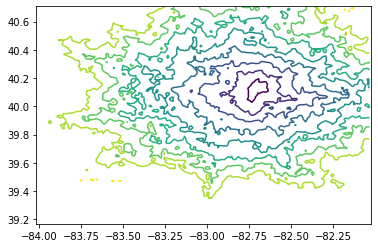

In [419]:
levels = [10,20,30,40,50,60,70,80,90]
contourList = []
contours = plt.contour(X,Y,Z, levels)

i = 0
for i in range(0, len(levels)-1):
    print("Generating isochrone for budget {}".format(levels[i]))
    thisContourList = []
    for contour in contours.allsegs[i]:
        try:
            poly = Polygon(contour)
        except:
            print("Warning: omitting incompatible geometry")
        thisContourList.append(poly)
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })
    
# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_car.shp", index=False)
isochrones

In [420]:
m = counties.explore(tiles="OpenStreetMap", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Walk + Bus

In [421]:
ttm = pd.read_csv("output_data/ttm_WALK-TRANSIT-WALK_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [422]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [423]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [424]:
tightgrid["travel_time"] = z

<AxesSubplot:>

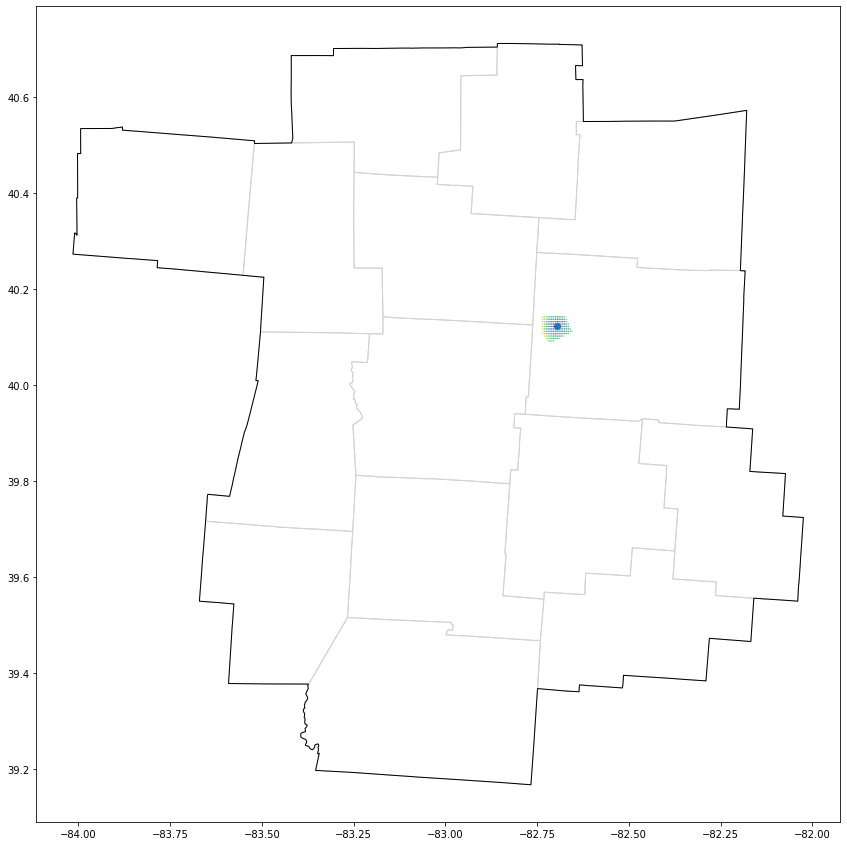

In [425]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [426]:
Z = z.reshape((len(y),len(x)))

Generating isochrone for budget 20
Generating isochrone for budget 30
Generating isochrone for budget 40
Generating isochrone for budget 50
Generating isochrone for budget 60
Generating isochrone for budget 70
Generating isochrone for budget 80


C:\Users\aporr\AppData\Local\Temp\ipykernel_14488\2484172952.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  isochrones.to_file("./output_data/isochrones_walk-transit-walk.shp", index=False)


travel_time                                           geometry
6           80  MULTIPOLYGON (((-82.72838 40.10138, -82.72908 ...
5           70  MULTIPOLYGON (((-82.71711 40.09277, -82.71976 ...
4           60  MULTIPOLYGON (((-82.67635 40.10618, -82.67976 ...
3           50  MULTIPOLYGON (((-82.69079 40.14277, -82.68976 ...
2           40  MULTIPOLYGON (((-82.69976 40.10993, -82.70444 ...
1           30  MULTIPOLYGON (((-82.69476 40.11554, -82.69965 ...
0           20  MULTIPOLYGON (((-82.69976 40.12571, -82.70203 ...

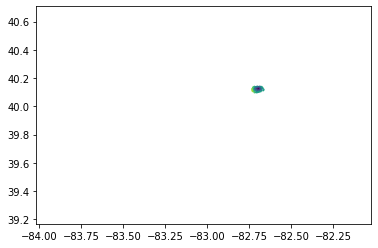

In [427]:
levels = [20,30,40,50,60,70,80,90]
contourList = []
contours = plt.contour(X,Y,Z, levels)

i = 0
for i in range(0, len(levels)-1):
    print("Generating isochrone for budget {}".format(levels[i]))
    thisContourList = []
    for contour in contours.allsegs[i]:
        try:
            poly = Polygon(contour)
        except:
            print("Warning: omitting incompatible geometry")
        thisContourList.append(poly)
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })
    
# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_walk-transit-walk.shp", index=False)
isochrones

In [428]:
m = counties.explore(tiles="OpenStreetMap", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Bike + Bus

In [429]:
ttm = pd.read_csv("output_data/ttm_BIKE-TRANSIT-BIKE_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [430]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [431]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [432]:
tightgrid["travel_time"] = z

<AxesSubplot:>

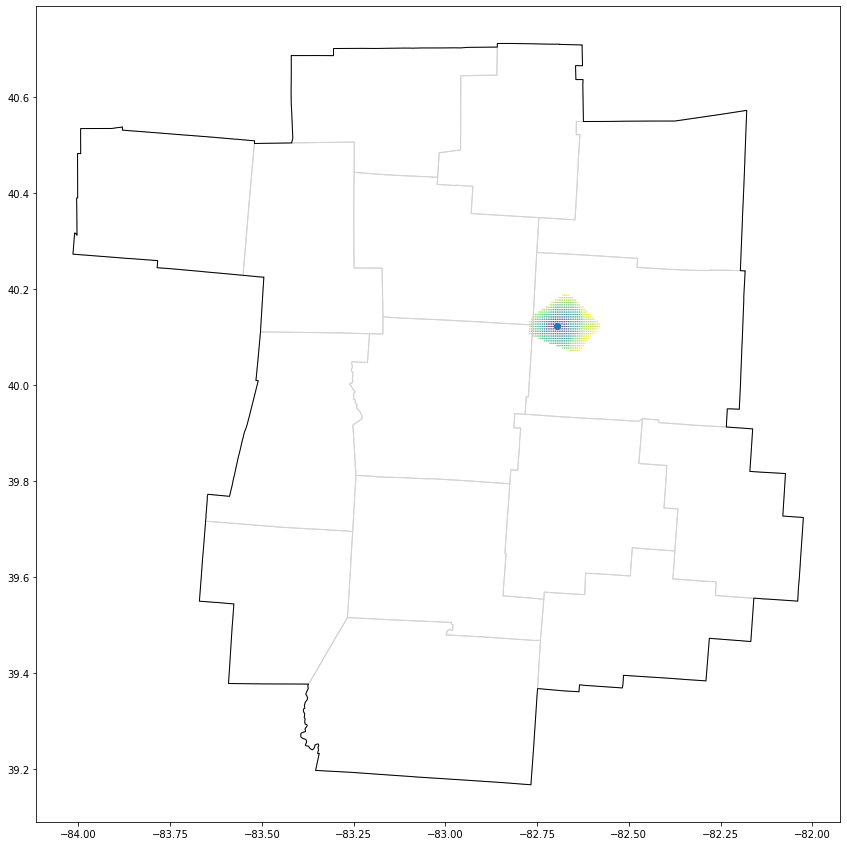

In [433]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [434]:
Z = z.reshape((len(y),len(x)))

Generating isochrone for budget 20
Generating isochrone for budget 30
Generating isochrone for budget 40
Generating isochrone for budget 50
Generating isochrone for budget 60
Generating isochrone for budget 70
Generating isochrone for budget 80


C:\Users\aporr\AppData\Local\Temp\ipykernel_14488\1290733408.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  isochrones.to_file("./output_data/isochrones_bike-transit-bike.shp", index=False)


travel_time                                           geometry
6           80  MULTIPOLYGON (((-82.76976 40.11259, -82.76972 ...
5           70  MULTIPOLYGON (((-82.69271 40.08277, -82.69476 ...
4           60  MULTIPOLYGON (((-82.68976 40.08747, -82.69469 ...
3           50  MULTIPOLYGON (((-82.69476 40.09639, -82.69710 ...
2           40  MULTIPOLYGON (((-82.68476 40.10267, -82.68511 ...
1           30  MULTIPOLYGON (((-82.68976 40.11263, -82.69030 ...
0           20  MULTIPOLYGON (((-82.71976 40.12209, -82.72033 ...

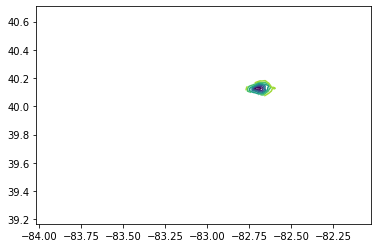

In [435]:
levels = [20,30,40,50,60,70,80,90]
contourList = []
contours = plt.contour(X,Y,Z, levels)

i = 0
for i in range(0, len(levels)-1):
    print("Generating isochrone for budget {}".format(levels[i]))
    thisContourList = []
    for contour in contours.allsegs[i]:
        try:
            poly = Polygon(contour)
        except:
            print("Warning: omitting incompatible geometry")
        thisContourList.append(poly)
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })
    
# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_bike-transit-bike.shp", index=False)
isochrones

In [436]:
m = counties.explore(tiles="OpenStreetMap", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Shuttle + Bus

In [437]:
ttm = pd.read_csv("output_data/ttm_SHUTTLE-TRANSIT-WALK_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [438]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [439]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [440]:
tightgrid["travel_time"] = z

<AxesSubplot:>

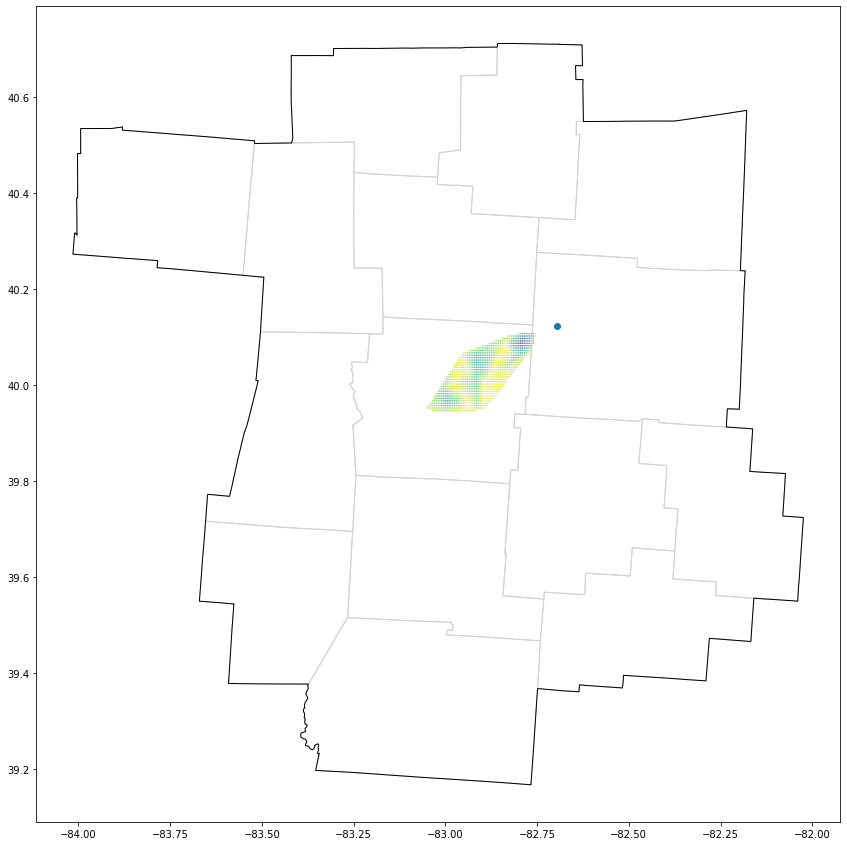

In [441]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [442]:
Z = z.reshape((len(y),len(x)))

Generating isochrone for budget 20
Generating isochrone for budget 30
Generating isochrone for budget 40
Generating isochrone for budget 50
Generating isochrone for budget 60
Generating isochrone for budget 70
Generating isochrone for budget 80


C:\Users\aporr\AppData\Local\Temp\ipykernel_14488\3084583047.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  isochrones.to_file("./output_data/isochrones_shuttle-transit-walk.shp", index=False)


travel_time                                           geometry
6           80                           GEOMETRYCOLLECTION EMPTY
5           70  MULTIPOLYGON (((-83.01153 39.94777, -83.01476 ...
4           60  MULTIPOLYGON (((-82.80321 40.10432, -82.79976 ...
3           50  MULTIPOLYGON (((-82.99976 39.96708, -83.00066 ...
2           40  MULTIPOLYGON (((-82.79976 40.07618, -82.80253 ...
1           30  MULTIPOLYGON (((-82.79976 40.08190, -82.80071 ...
0           20  MULTIPOLYGON (((-82.79476 40.08490, -82.79781 ...

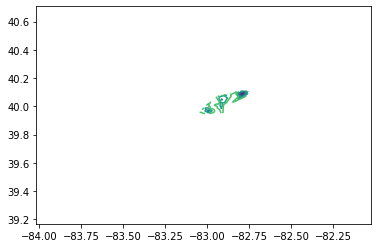

In [443]:
levels = [20,30,40,50,60,70,80,90]
contourList = []
contours = plt.contour(X,Y,Z, levels)

i = 0
for i in range(0, len(levels)-1):
    print("Generating isochrone for budget {}".format(levels[i]))
    thisContourList = []
    for contour in contours.allsegs[i]:
        try:
            poly = Polygon(contour)
        except:
            print("Warning: omitting incompatible geometry")
        thisContourList.append(poly)
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })
    
# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_shuttle-transit-walk.shp", index=False)
isochrones

In [444]:
m = counties.explore(tiles="OpenStreetMap", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

TypeError: 'NoneType' object is not subscriptable

## Create detailed itineraries

### Transit + shuttle or bike

In [264]:
itineraries = gpd.read_file("./output_data/itineraries_ANY_toconference_150.shp")
destination = 324
singleItinerary = itineraries.loc[(itineraries["toId"] == str(destination)) & (itineraries["option"] == 2)].copy()
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = tract_points.loc[tract_points["id"] == destination]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="CartoDB positron", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 88.65 total, 80.51666666666665 travel, 8.133333333333333 wait
Walking distance (meters): 504
Biking distance (meters): 0


In [265]:
itineraries = gpd.read_file("./output_data/itineraries_SHUTTLE_TRANSIT_WALK_outbound_120.shp")
destination = 324
singleItinerary = itineraries.loc[itineraries["toId"] == str(destination)].copy()
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = tract_points.loc[tract_points["id"] == destination]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="CartoDB positron", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 88.65 total, 76.69999999999999 travel, 11.95 wait
Walking distance (meters): 582
Biking distance (meters): 0


In [266]:
itineraries = gpd.read_file("./output_data/itineraries_SHUTTLE_firstmile.shp")
destination = 0
singleItinerary = itineraries.loc[itineraries["toId"] == str(destination)].copy()
singleItinerary["mode"] = singleItinerary["mode"].str.replace("CAR","SHUTTLE")
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = park_and_ride.loc[tract_points["id"] == destination]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="CartoDB positron", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 13.3 total, 13.3 travel, 0.0 wait
Walking distance (meters): 0
Biking distance (meters): 0


## Appendix: Create grid of destination points

In [ ]:
raise RuntimeError

<AxesSubplot:>

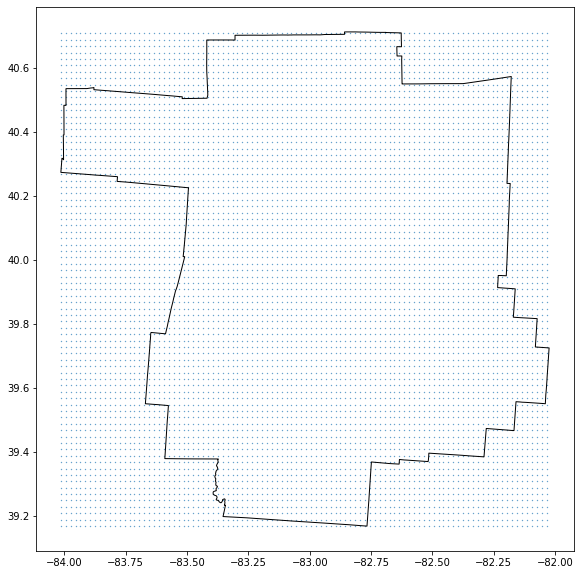

In [267]:
GRIDSPACING = 0.02

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(X.ravel(), Y.ravel()))
points = points.reset_index().rename(columns={"index":"id"})

points.to_file("./temp_data/points_raw.shp")

ax = points.plot(markersize=0.1, figsize=(10,10))
region.plot(ax=ax, edgecolor="black", facecolor="none")

# Final step: In ArcPro, run Default.tbx\r5prep to snap grid points to OSM road network

## Appendix: Create regional county boundaries dataset

In [ ]:
raise RuntimeError

In [154]:
counties_all = gpd.read_file("./input_data/counties/cb_2021_us_county_500k.shp")

In [160]:
counties_region = counties_all.loc[(counties_all["STATE_NAME"] == "Ohio") & (counties_all["COUNTYFP"].isin(COUNTY_LIST.values()))]

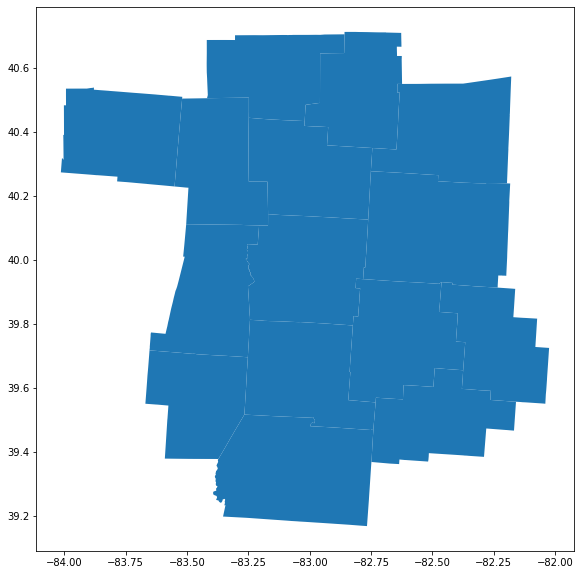

In [161]:
ax = counties_region.plot(figsize=(10,10))

In [162]:
counties_region.to_file("./temp_data/counties.shp")

## Appendix: Create region boundary dataset

In [ ]:
raise RuntimeError

<AxesSubplot:>

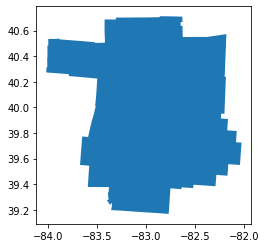

In [163]:
region = counties_region.dissolve()
region.plot()

In [164]:
region.to_file("./temp_data/region.shp")

## Appendix: Create tract boundaries and centroids datasets

<AxesSubplot:>

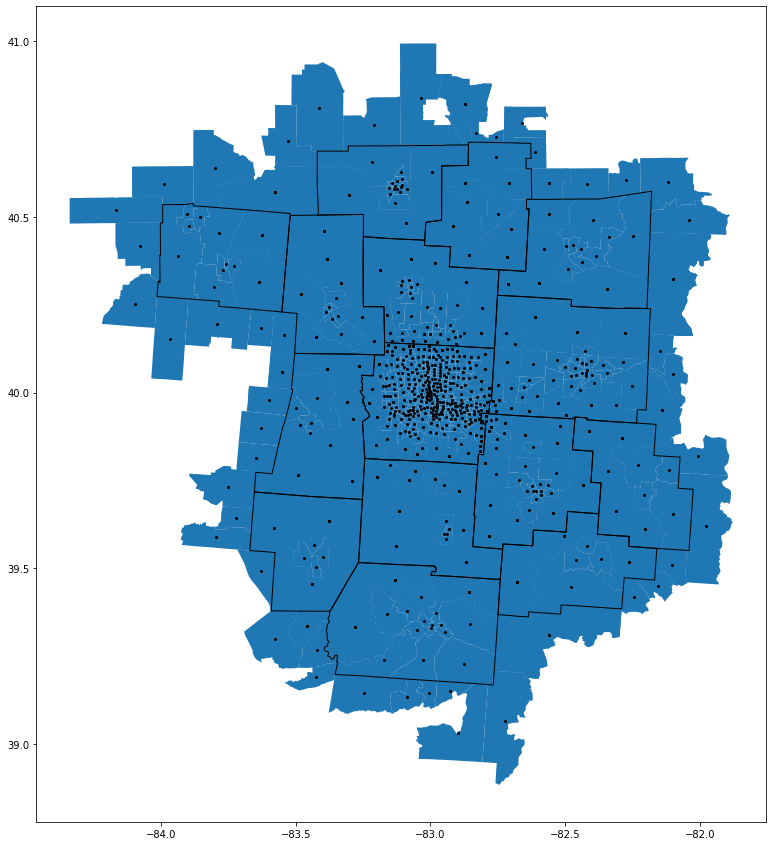

In [287]:
tracts_all = gpd.read_file("./input_data/tracts/tl_2021_39_tract.shp")

tracts_region = gpd.sjoin(tracts_all.to_crs(epsg=3735), counties_region[["COUNTYFP","geometry"]].to_crs(epsg=3735), how='left', predicate='intersects', lsuffix='left', rsuffix='right')

tracts_region = tracts_region.loc[tracts_region["COUNTYFP_right"].notna()] \
    .filter(axis="columns", items=["GEOID", "COUNTYFP_left", "geometry"]) \
    .rename(columns={
        "GEOID_left":"GEOID",
        "COUNTYFP_left":"COUNTYFP"
    }) \
    .to_crs(epsg=4326)

tracts_region["centroid"] = tracts_region.to_crs(epsg=3735).centroid.to_crs(epsg=4326)

tract_centroids = gpd.GeoDataFrame(data=tracts_region.drop(columns=["geometry"]), geometry=tracts_region["centroid"])
tract_centroids = tract_centroids \
    .drop(columns=["centroid"]) \
    .rename(columns={"GEOID":"id"})

tracts_region = tracts_region.drop(columns=["centroid"])

tracts_region.to_file("./temp_data/tracts.shp")
tract_centroids.to_file("./temp_data/tract_points_raw.shp")

ax = tracts_region.plot(figsize=(15,15))
tract_centroids.plot(ax=ax, color="black", markersize=4)
counties_region.plot(ax=ax, edgecolor="black", facecolor="none")

# Final step: In ArcPro, run Default.tbx\r5prep to snap tract centroids to OSM road network

## Appendix: Download census population data

In [ ]:
raise RuntimeError

In [123]:
blocks_raw = gpd.read_file("./input_data/blocks/tl_2021_39_tabblock20.shp", dtype="object")

In [167]:
blocks = blocks_raw.copy()

In [168]:
blocks = blocks.loc[blocks["COUNTYFP20"].isin(COUNTY_LIST.values())]
blocks = blocks \
    .rename(columns={
        "COUNTYFP20":"COUNTYFP",
        "GEOID20":"GEOID"
    }) \
    .filter(axis="columns", items=["GEOID", "COUNTYFP", "geometry"])                                   

In [169]:
r = requests.get("https://api.census.gov/data/2020/dec/pl?get=GEO_ID,P1_001N&for=block:*&in=state:39%20county:{}".format(",".join(COUNTY_LIST.values())))
records = r.json()
columns = records.pop(0)
blockData = pd.DataFrame.from_records(records, columns=columns)
blockData.to_csv("./input_data/blocks/blockData.csv", index=False)

In [171]:
blockData = pd.read_csv("./input_data/blocks/blockData.csv", dtype="object")
blockData = blockData.loc[blockData["county"].isin(COUNTY_LIST.values())]
blockData["GEOID"] = blockData["GEO_ID"].apply(lambda x:x.split("US")[1])
blockData = blockData \
    .rename(columns={
        "county":"COUNTYFP",
        "P1_001N":"TOTALPOP"
    }) \
    .filter(axis="columns", items=["GEOID", "COUNTYFP", "TOTALPOP"])                                   

In [172]:
blocks = blocks \
    .merge(blockData, left_on="GEOID", right_on="GEOID") \
    .filter(axis="columns", items=["GEOID","COUNTYFP_x", "TOTALPOP", "geometry"]) \
    .rename(columns={"COUNTYFP_x":"COUNTYFP"})
blocks.to_file("./temp_data/blocks.shp")
blocks.head()

GEOID COUNTYFP TOTALPOP  \
0  390970412003030      097       27   
1  390970412003005      097       94   
2  390970412002014      097        0   
3  390970411004019      097        1   
4  390970413001057      097        1   

                                            geometry  
0  POLYGON ((-83.27196 39.71246, -83.27196 39.712...  
1  POLYGON ((-83.28681 39.71786, -83.28154 39.719...  
2  POLYGON ((-83.25954 39.71574, -83.25571 39.718...  
3  POLYGON ((-83.39468 39.89435, -83.39383 39.894...  
4  POLYGON ((-83.59370 39.76228, -83.59240 39.762...

## Appendix: Review sample location routing results

In [253]:
temp = pd.read_csv("./input_data/sample_locations.csv")
sample_locations = gpd.GeoDataFrame(data=temp, geometry=gpd.GeoSeries.from_xy(x=temp["lon"], y=temp["lat"]))

In [263]:
temp = pd.read_csv("./output_data/ttm_sample_locations_car.csv")
travel_times_car = sample_locations.merge(temp, left_on="id", right_on="toId")
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
travel_times_car.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})

In [261]:
temp = pd.read_csv("./output_data/ttm_sample_locations_bike.csv")
travel_times_bike = sample_locations.merge(temp, left_on="id", right_on="toId")
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
travel_times_bike.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})

In [262]:
temp = pd.read_csv("./output_data/ttm_sample_locations_transit.csv")
travel_times_transit = sample_locations.merge(temp, left_on="id", right_on="toId")
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
travel_times_transit.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})